<a href="https://www.kaggle.com/code/amirmotefaker/telecom-customer-churn-prediction?scriptVersionId=129673115" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Telecom Customer Churn Prediction
- Churn is a one of the biggest problem in the telecom industry. 

- For Telco companies it is key to attract new customers and at the same time avoid contract terminations to grow their revenue-generating base. Looking at churn, different reasons trigger customers to terminate their contracts, for example, better price offers more interesting packages, bad service experiences, or changes in customers’ personal situations.

- Telcos apply machine learning models to predict churn on an individual customer basis and take countermeasures such as discounts, special offers, or other gratifications to keep their customers. A customer churn analysis is a typical classification problem within the domain of supervised learning.

- Churn analytics provides valuable capabilities to predict customer churn and also define the underlying reasons that drive it. The churn metric is mostly shown as the percentage of customers that cancel a product or service within a given period (mostly months).

- I have explored the following classficiation techniques and compared their accuracy and other metrics such as: 
   - ROC-AUC score
   - True Positive Rate and False Positive Rate
   
### What is churn analytics?
- Churn analytics is the process of measuring and understanding the rate at which customers quit the product, site, or service. 
- Churn analytics can help you understand how frequently customers churn out of the product and where this tends to occur. 
- Help you understand which features and functionality are important for keeping customers in your product. 
- Churn analytics is critical for getting a performance overview, identifying improvements and understanding which channels are driving the most value.

# Importing Libraries

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt

sns.set(style = 'white')

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
from datetime import datetime
import lightgbm as lgbm # LightGBM is a gradient boosting framework that uses tree based learning algorithms. 
import warnings

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import warnings

from contextlib import contextmanager
# @contextlib.contextmanager
# This function is a decorator that can be used to define a factory function for with statement context managers,
# without needing to create a class or separate __enter__() and __exit__() methods.
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

warnings.filterwarnings('ignore') #ignore warning messages

# EDA

In [47]:
data = pd.read_csv('/kaggle/input/telcom-customer-churn/Telco-Customer-Churn.csv')

In [48]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [49]:
data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [50]:
# Checking the data types of all the columns
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [51]:
# Converting Total Charges to a numerical data type.
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [52]:
#Removing missing values 
data.dropna(inplace = True)

In [53]:
#Remove customer IDs from the data set
df2 = data.iloc[:,1:]

In [54]:
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [55]:
#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


<AxesSubplot:>

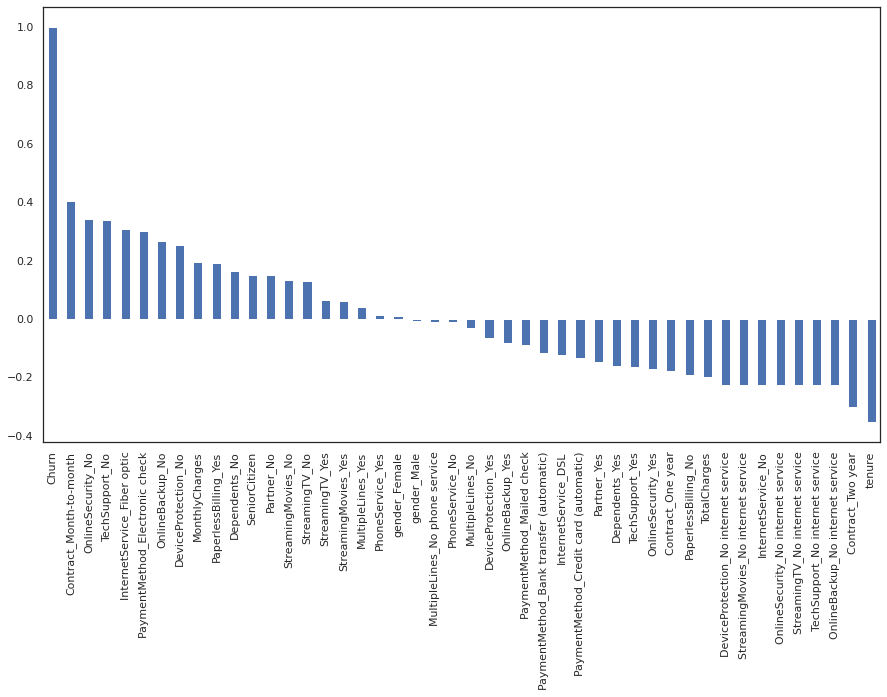

In [56]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

- Contracts month to month, absence of online security and tech support seem to be positively correlated with churn.

- Tenure, two year contracts seem to be negatively correlated with churn.

- Services such as Online security, streaming TV, online backup, tech support, etc. without internet connection seem to be negatively related to churn.

# A.) Demographics - Let us first understand the gender, age range, partner, and dependent status of the customers.

## 1. Gender Distribution

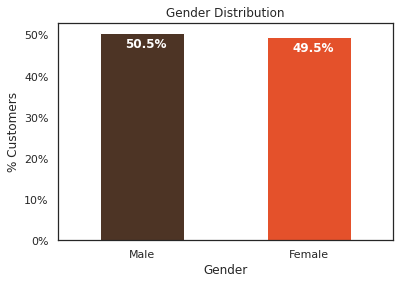

In [57]:
colors = ['#4D3425','#E4512B']
ax = (data['gender'].value_counts()*100.0 /len(data)).plot(kind='bar',
                                                           stacked = True,
                                                           rot = 0,
                                                           color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
            weight = 'bold')

- About half of the customers in our data set are male while the other half are female

## 2. % Senior Citizens

Text(0, 0.5, 'Senior Citizens')

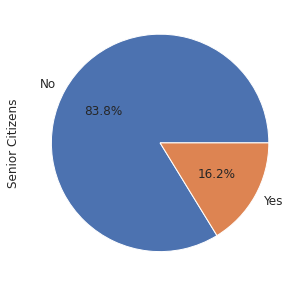

In [58]:
ax = (data['SeniorCitizen'].value_counts()*100.0 /len(data))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)

- There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.

## 3. Partner and dependent status

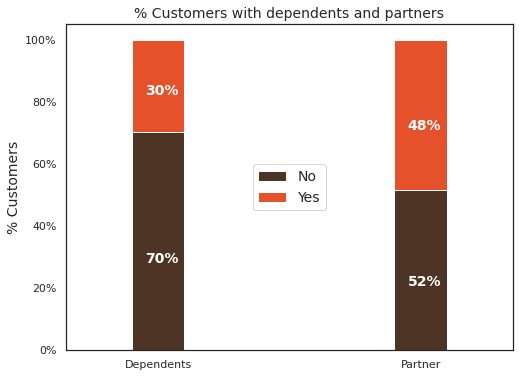

In [59]:
df2 = pd.melt(data, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(data)
colors = ['#4D3425','#E4512B']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                      width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
                weight = 'bold',
                size = 14)

- About 50% of the customers have a partner, while only 30% of the total customers have dependents.

- What would be interesting is to look at the % of customers, who have partners, also have dependents. We will explore this next.

- Interestingly, among the customers who have a partner, only about half of them also have a dependent, while the other half do not have any independents. Additionally, as expected, among the customers who do not have any partner, a majority (80%) of them do not have any dependents.

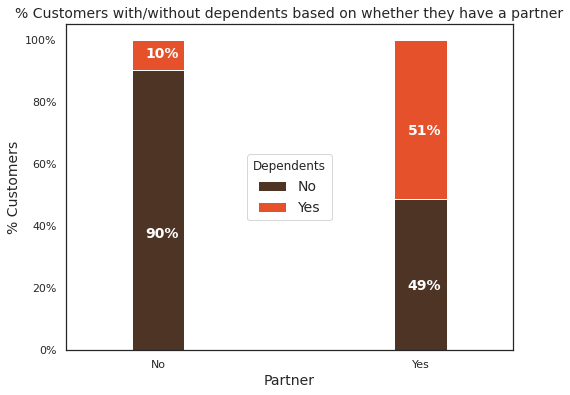

In [60]:
colors = ['#4D3425','#E4512B']
partner_dependents = data.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                      width = 0.2,
                                                                      stacked = True,
                                                                      rot = 0, 
                                                                      figsize = (8,6),
                                                                      color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
                weight = 'bold',
                size = 14)

- I also looked at any differences between the % of customers with/without dependents and partners by gender. There is no difference in their distribution by gender.
- Additionally, there is no difference in senior citizen status by gender.

# B.) Customer Account Information

### 1.Tenure

Text(0.5, 1.0, '# of Customers by their tenure')

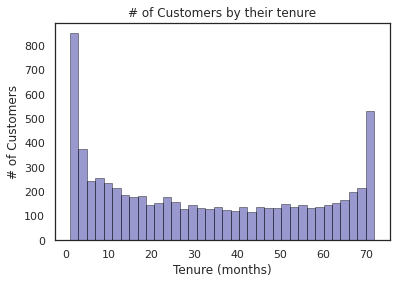

In [61]:
ax = sns.distplot(data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

- Looking at the above histogram we can see that a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. This could be potentially because different customers have different contracts. Thus based on the contract they are into it could be more/less easier for the customers to stay/leave the telecom company.

### 2. Contracts:
- To understand the above graph, lets first look at the # of customers by different contracts.

Text(0.5, 1.0, '# of Customers by Contract Type')

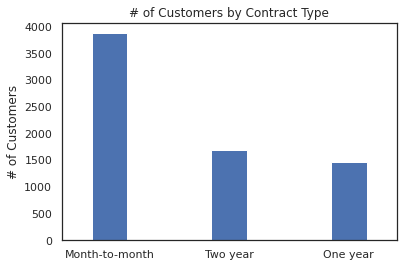

In [62]:
ax = data['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

- As we can see from this graph most of the customers are in the month-to-month contract. While there are an equal number of customers in the 1 year and 2-year contracts.

### Now, we will understand the tenure of customers based on their contract type:

Text(0.5, 1.0, 'Two Year Contract')

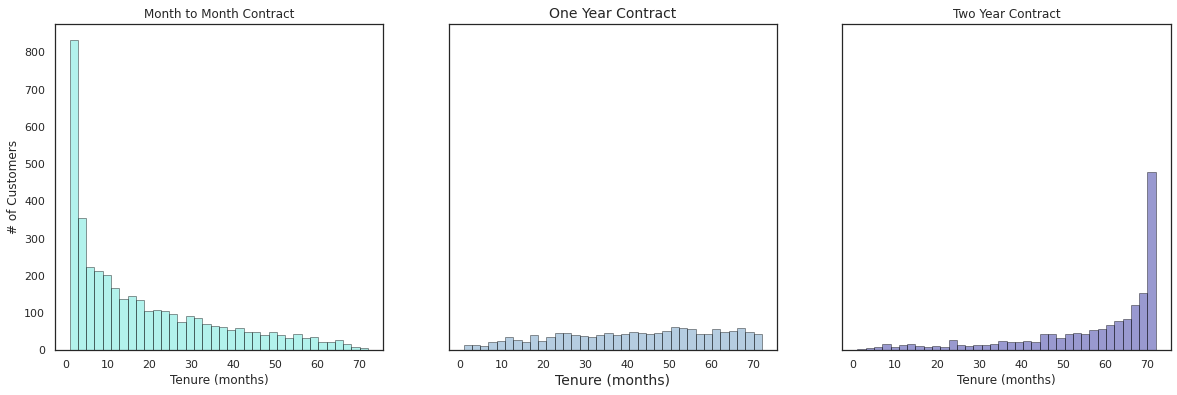

In [63]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(data[data['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(data[data['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(data[data['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

- Most of the monthly contracts last for 1-2 months, while the 2 year contracts tend to last for about 70 months.

- This shows that the customers taking a longer contract are more loyal to the company and tend to stay with it for a longer period of time.

- This is also what we saw in the earlier chart on correlation with the churn rate.

# C.) Distribution of various services used by customers

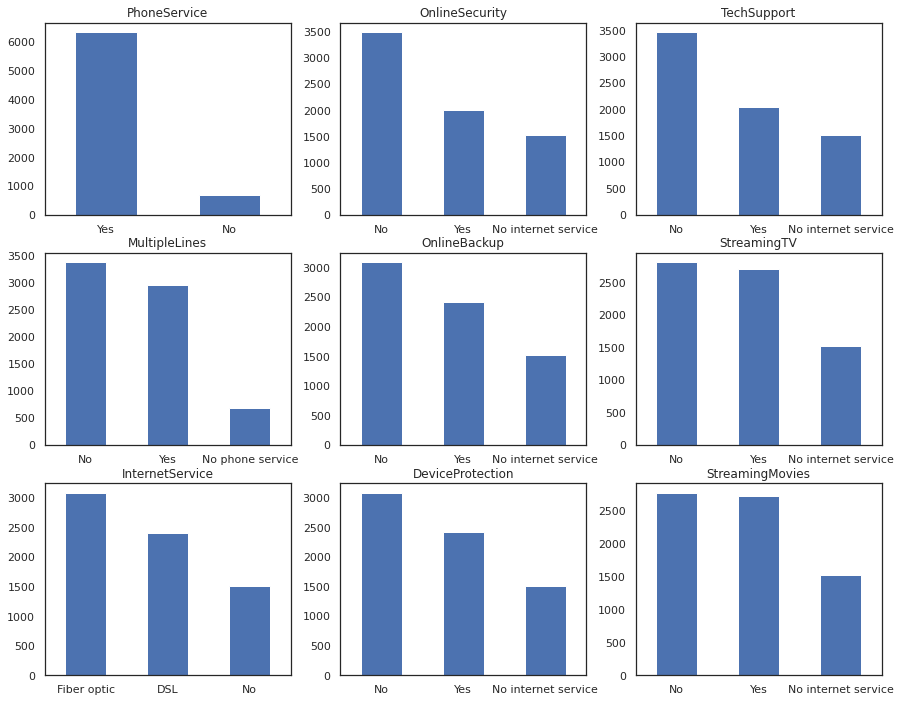

In [64]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

# D.) Relation between monthly and total charges

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

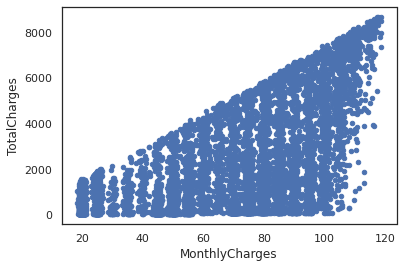

In [65]:
data[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                      y='TotalCharges')

- Observe that the total charges increase as the monthly bill for a customer increases.

# E.) Predictor variable (Churn) and interaction with other important variables.

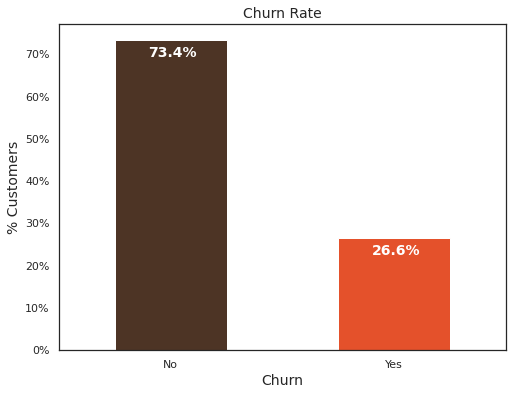

In [66]:
colors = ['#4D3425','#E4512B']
ax = (data['Churn'].value_counts()*100.0 /len(data)).plot(kind='bar',
                                                                           stacked = True,
                                                                           rot = 0,
                                                                           color = colors,
                                                                           figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            color='white',
            weight = 'bold',
            size = 14)

- In above data, 74% of the customers do not churn.
- Clearly the data is skewed as we would expect a large majority of the customers to not churn.
- This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives.

### 1.) Churn vs Tenure: Explore the churn rate by tenure, seniority, contract type, monthly charges and total charges to see how it varies by these variables.

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

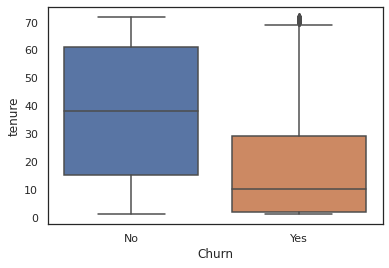

In [67]:
sns.boxplot(x = data.Churn, y = data.tenure)

- As we can see form the above plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.

### 2.) Churn by Contract Type:

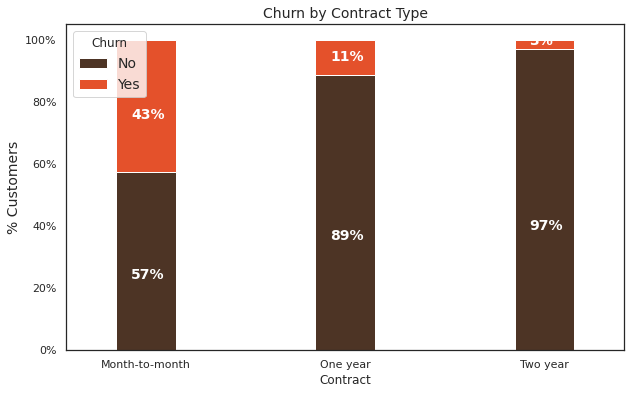

In [68]:
colors = ['#4D3425','#E4512B']
contract_churn = data.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
                weight = 'bold',
                size = 14)

- Similar to what we saw in the correlation plot, the customers who have a month to month contract have a very high churn rate.

### 3.) Churn by Seniority Level:

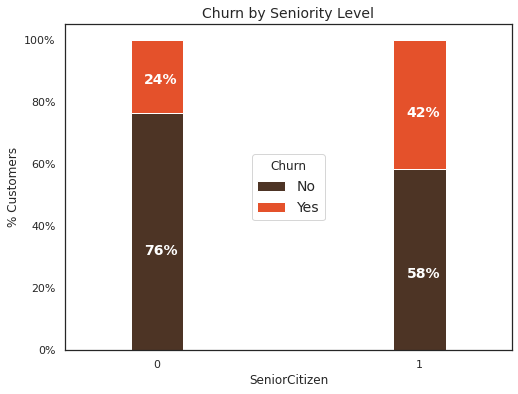

In [69]:
colors = ['#4D3425','#E4512B']
seniority_churn = data.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
                weight = 'bold',size =14)

### 4.) Churn by Monthly Charges:

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

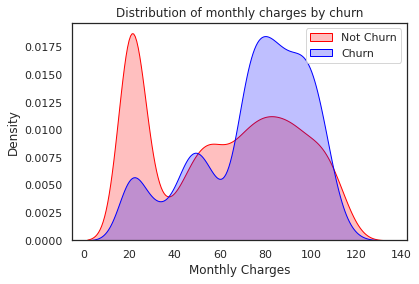

In [70]:
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

- Higher % of customers churn when the monthly charges are high.

### 5.) Churn by Total Charges:

Text(0.5, 1.0, 'Distribution of total charges by churn')

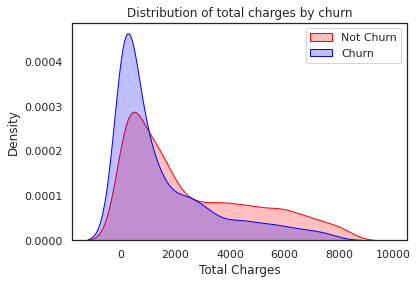

In [71]:
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

- There is higher churn when the total charges are lower.

# Scaling the data

### We will use the data frame where we had created dummy variables:


In [72]:
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

### Scaling all the variables to a range of 0 to 1:

In [73]:
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

- It is essential to scale the variables in logistic regression so that they are within a range of 0 to 1.
- This helped us improve the accuracy from 79.7% to 80.7%. Further, you will notice below that the importance of variables is also aligned with what we see in the Random Forest algorithm and the EDA we conducted above.

### Create Train & Test Data:


In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Getting the Accuracy, Confusion Matrix, ROC Curve, ROC-AUC score and TPR/FPR rate also called as Specificity & Sensitivity

### 1. Accuracy - It is calculated on the test data set

### 2. Confusion Matrix - It tells us how many True Positive/True Negatives and False Positives/False Negatives are present in the prediction

    a. TP: Number of customers who will actually default also predicted as default

    b. TN: Number of customers who won't actually default also predicted as no default

    c. FP: Number of customers who won't actually default but predicted as default

    d. FN: Number of customers who will actually default but predicted as no default

- Note: It is important for a Telecom company to know more about the customers who are likely to default. Thus it is fine to have more False Positives (FP's), however we must have a lower # of FN, because this will predict more risky customers to be not that risky. This is important to keep in mind as we evaluate al the different classification models. We shoud choose the right threshold (even if it eans reducing the accuracy a bit to get better TPR).

### 3. ROC curve - It is a plot between Sensitivity and 1-Specificity predictions for all the different thresholds

### 4. ROC-AUC score - It is the area under the ROC curve. It helps us compare different models. Higher AUC implies a better model.

# Function to print acuracy score, ROC curvey, ROC-AUC score and confusion matrix

In [75]:
def model_performance(model) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #Feature importance
    coefficients  = pd.DataFrame(eval(model).feature_importances_)
    column_data   = pd.DataFrame(list(data))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients", 
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve',
                                          'Feature importance'
                                          ))
    
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white')
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white')
    fig["layout"]["xaxis6"].update(color = 'white')
    fig["layout"]["yaxis6"].update(color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

# Function for Cross Validation

In [76]:
# Cross Validation metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [77]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# 1. Light GBM Without Hyperparameter Tuning
- Light GBM(Light Gradient Boosting Machine): A fast, distributed, high performance gradient boosting (GBT, GBDT, GBRT, GBM or MART) framework based on decision tree algorithms, used for ranking, classification and many other machine learning tasks.

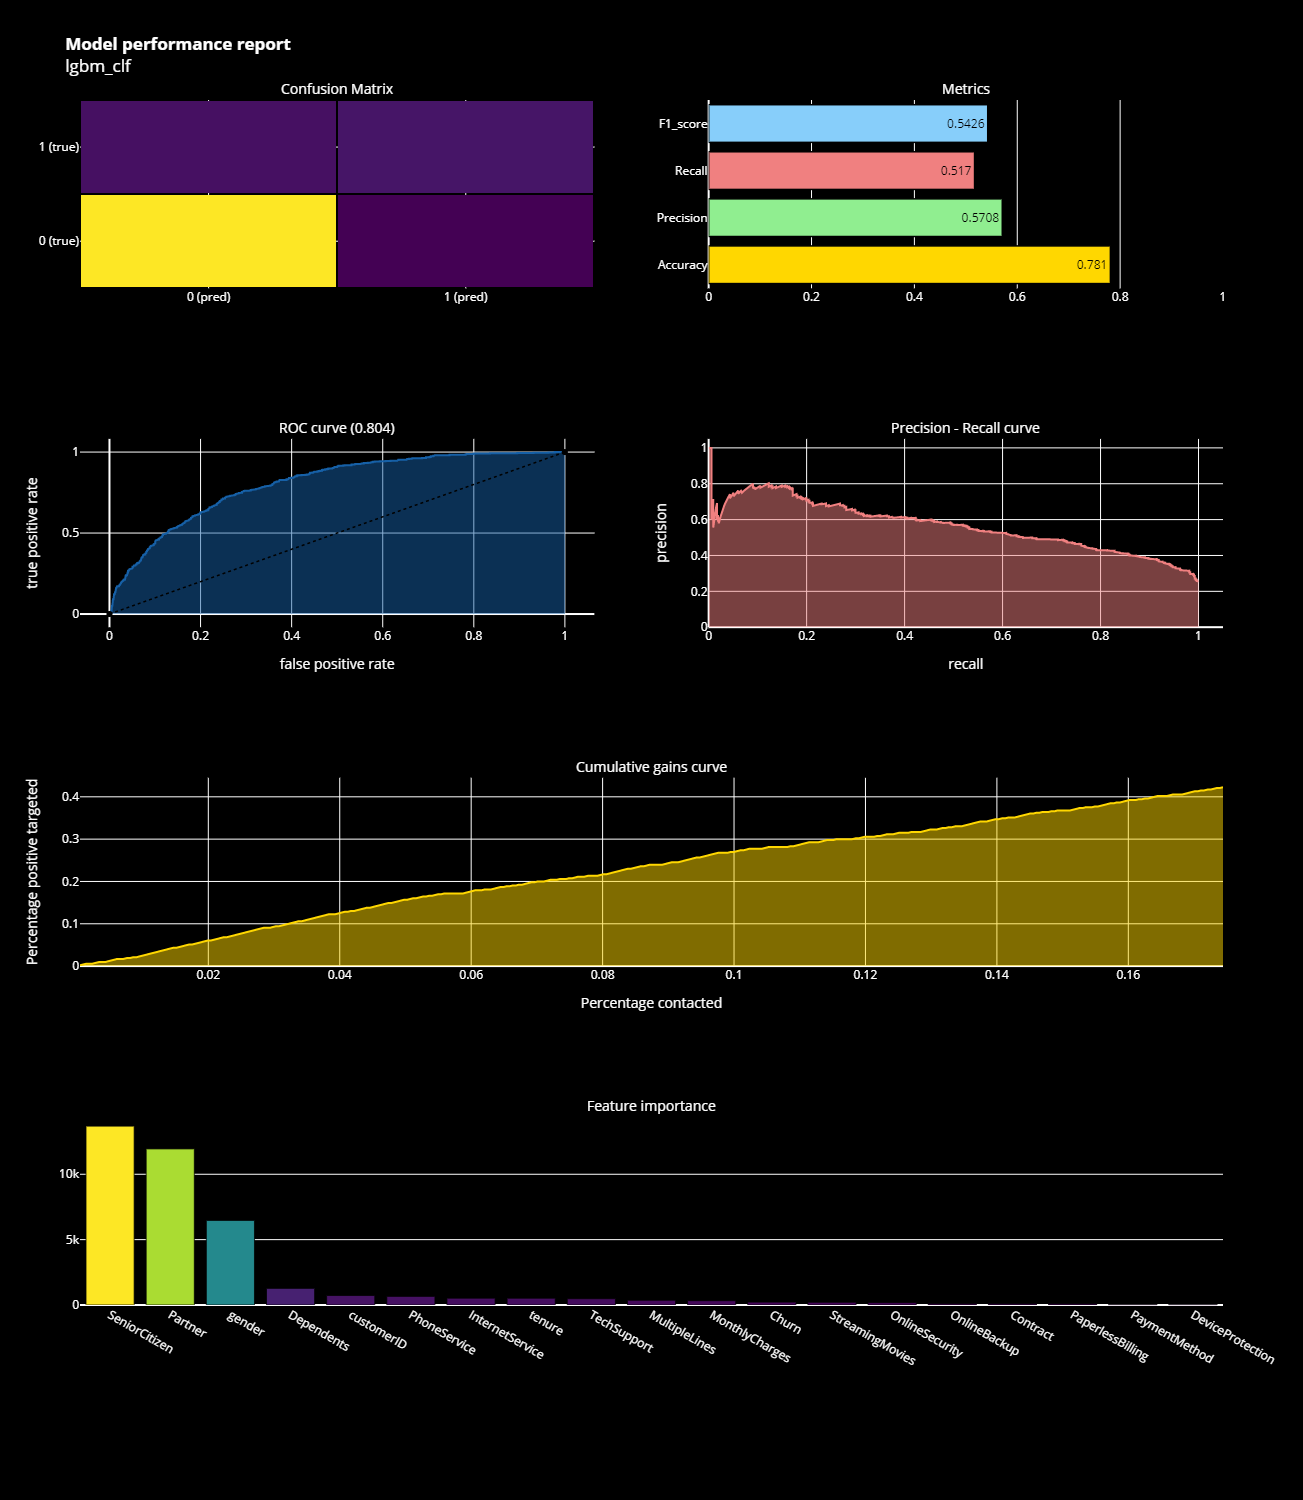

CPU times: user 17 s, sys: 631 ms, total: 17.6 s
Wall time: 4.61 s


In [78]:
%%time
lgbm_clf = lgbm.LGBMClassifier(n_estimators=1500, random_state = 42)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

model_performance('lgbm_clf')

## Randomized GridSearch

In [79]:
random_state = 42

In [80]:
fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_test,y_test)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 200

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_train, y_train, **fit_params)
print('Best params: {} '.format(grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'colsample_bytree': 0.5254784746471085, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_samples': 348, 'min_child_weight': 100.0, 'n_estimators': 800, 'num_leaves': 21, 'reg_alpha': 7, 'reg_lambda': 100, 'subsample': 0.7126997958425718} 


## Light GBM after Random Gridsearch

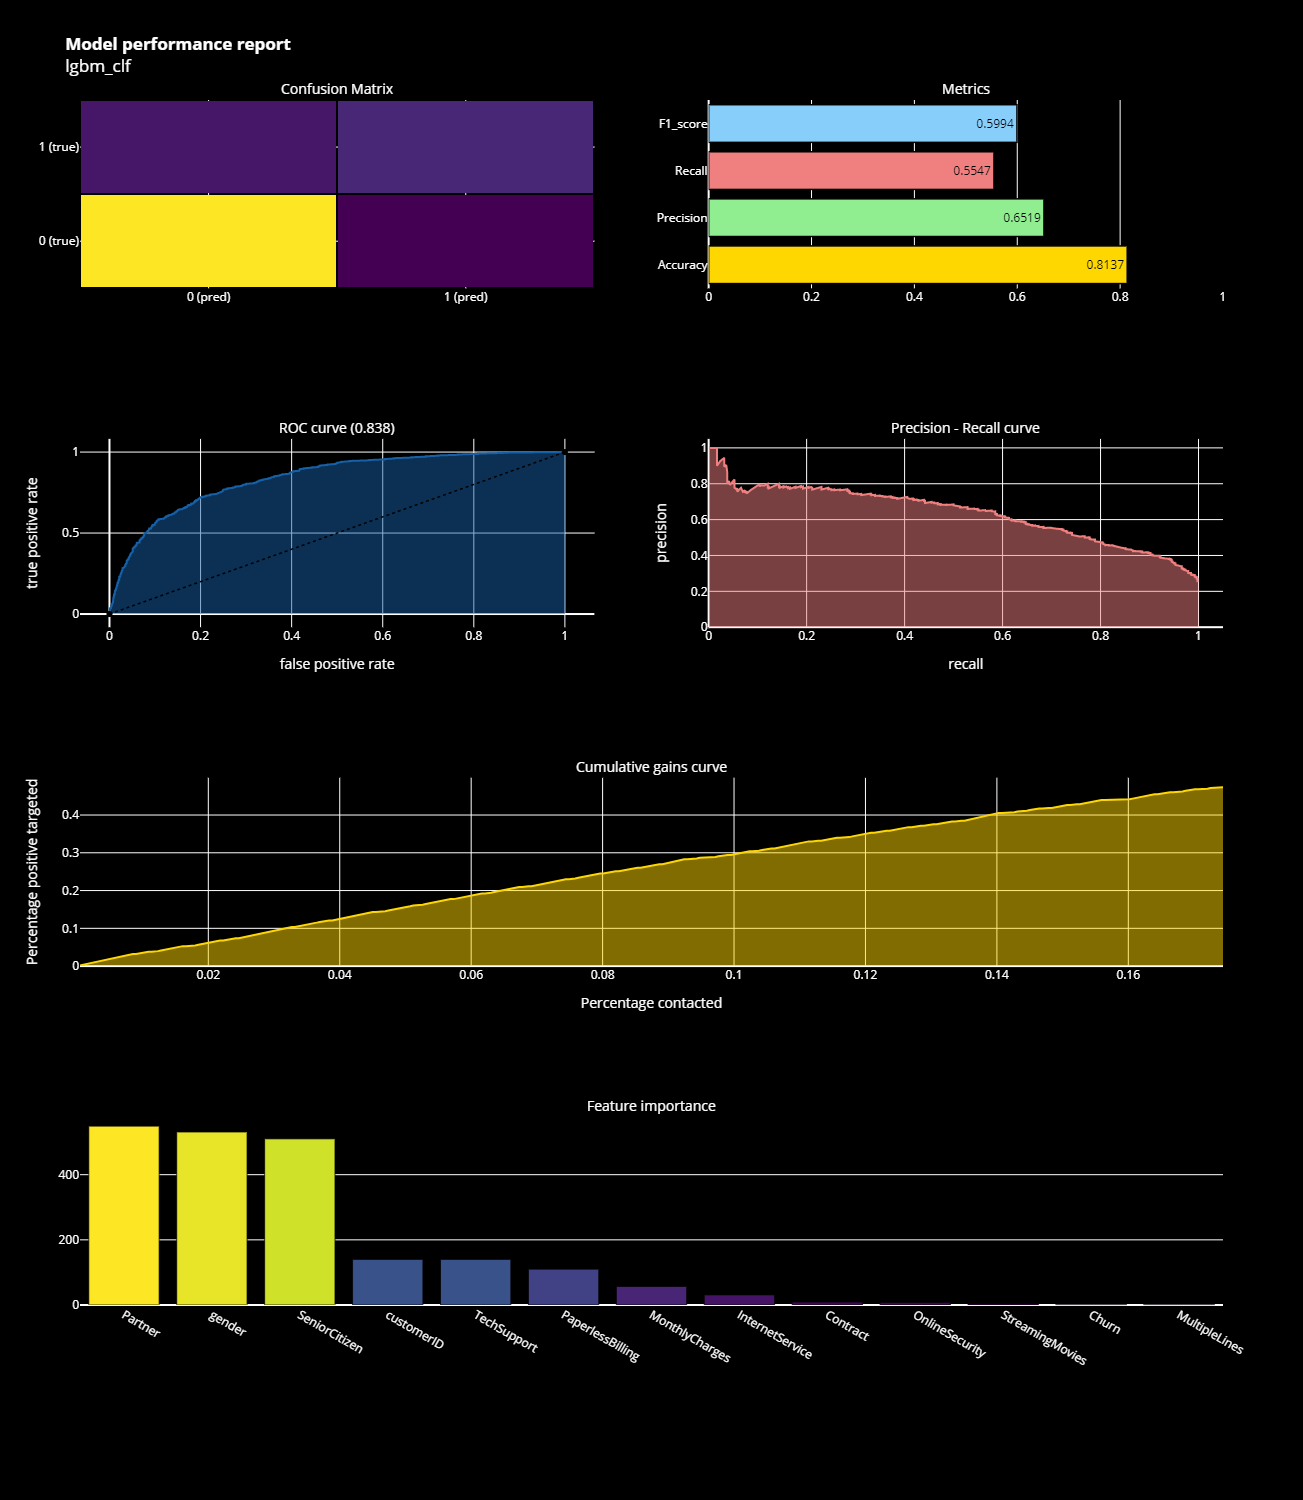

CPU times: user 3.65 s, sys: 64.9 ms, total: 3.71 s
Wall time: 1.08 s


In [81]:
%%time
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

model_performance('lgbm_clf')

## Cross Validation Light GBM ( 5CVs)

In [82]:
cross_val_metrics(lgbm_clf)

[accuracy] : 0.80589 (+/- 0.00917)
[precision] : 0.66685 (+/- 0.02278)
[recall] : 0.53931 (+/- 0.01624)
[f1] : 0.59629 (+/- 0.01831)
[roc_auc] : 0.84904 (+/- 0.00935)


# 2. Logistic Regression

In [83]:
# Defining function for Logistic Regression
def model_performance(model) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    # Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    # Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
#     #Feature importance
#     coefficients  = pd.DataFrame(eval(model).feature_importances_)
#     column_data   = pd.DataFrame(list(data))
#     coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
#                               right_index= True, how = "left"))
#     coef_sumry.columns = ["coefficients","features"]
#     coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
#     coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
#     trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
#                     name = "coefficients", 
#                     marker = dict(color = coef_sumry["coefficients"],
#                                   colorscale = "Viridis",
#                                   line = dict(width = .6,color = "black")))
    
    # Cumulative gain
    pos = pd.get_dummies(y_test).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    # Subplots
    fig = tls.make_subplots(rows=3, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve'
                                          ))
    
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white')
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white')
    #fig["layout"]["xaxis6"].update(color = 'white')
    #fig["layout"]["yaxis6"].update(color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

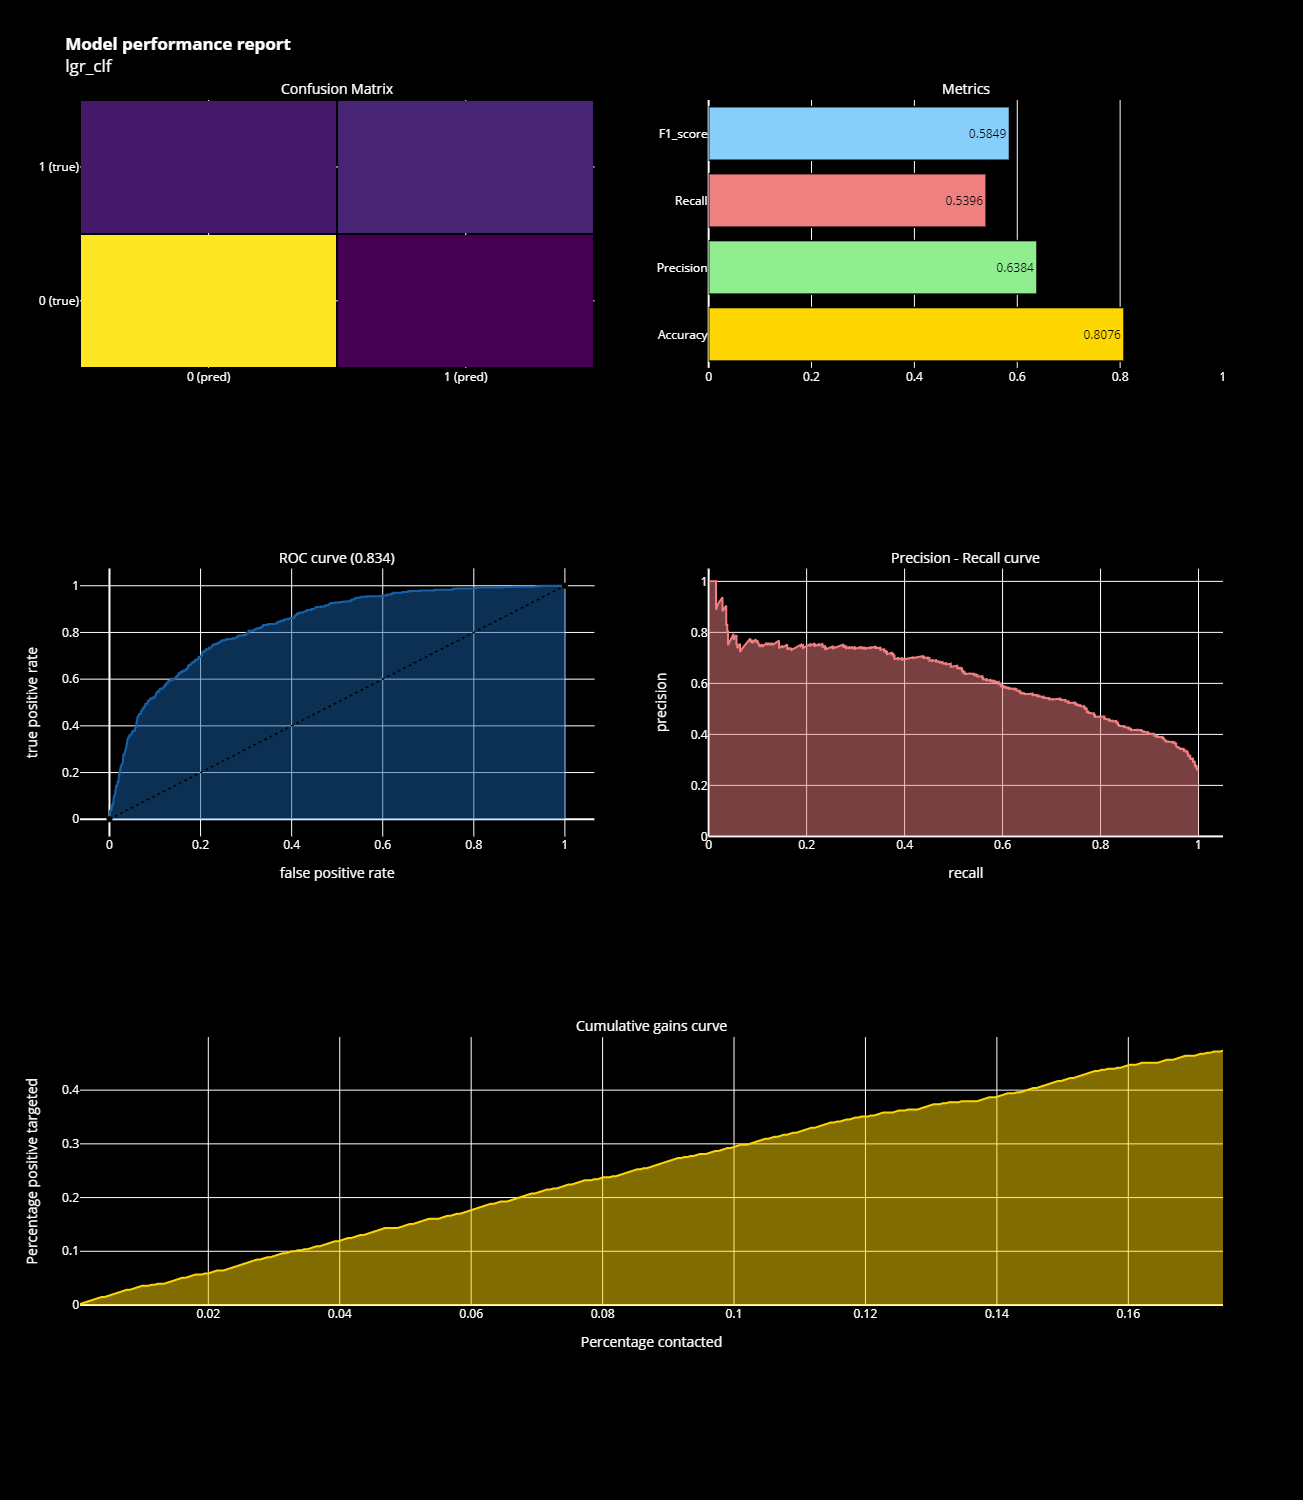

In [84]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression

lgr_clf = LogisticRegression()
lgr_clf.fit(X_train, y_train)
y_pred = lgr_clf.predict(X_test)
y_score = lgr_clf.predict_proba(X_test)[:,1]

model_performance('lgr_clf')

In [85]:
cross_val_metrics(lgr_clf)

[accuracy] : 0.80290 (+/- 0.00783)
[precision] : 0.65434 (+/- 0.01629)
[recall] : 0.54733 (+/- 0.02174)
[f1] : 0.59600 (+/- 0.01902)
[roc_auc] : 0.84457 (+/- 0.01098)


# 3. AdaBoost

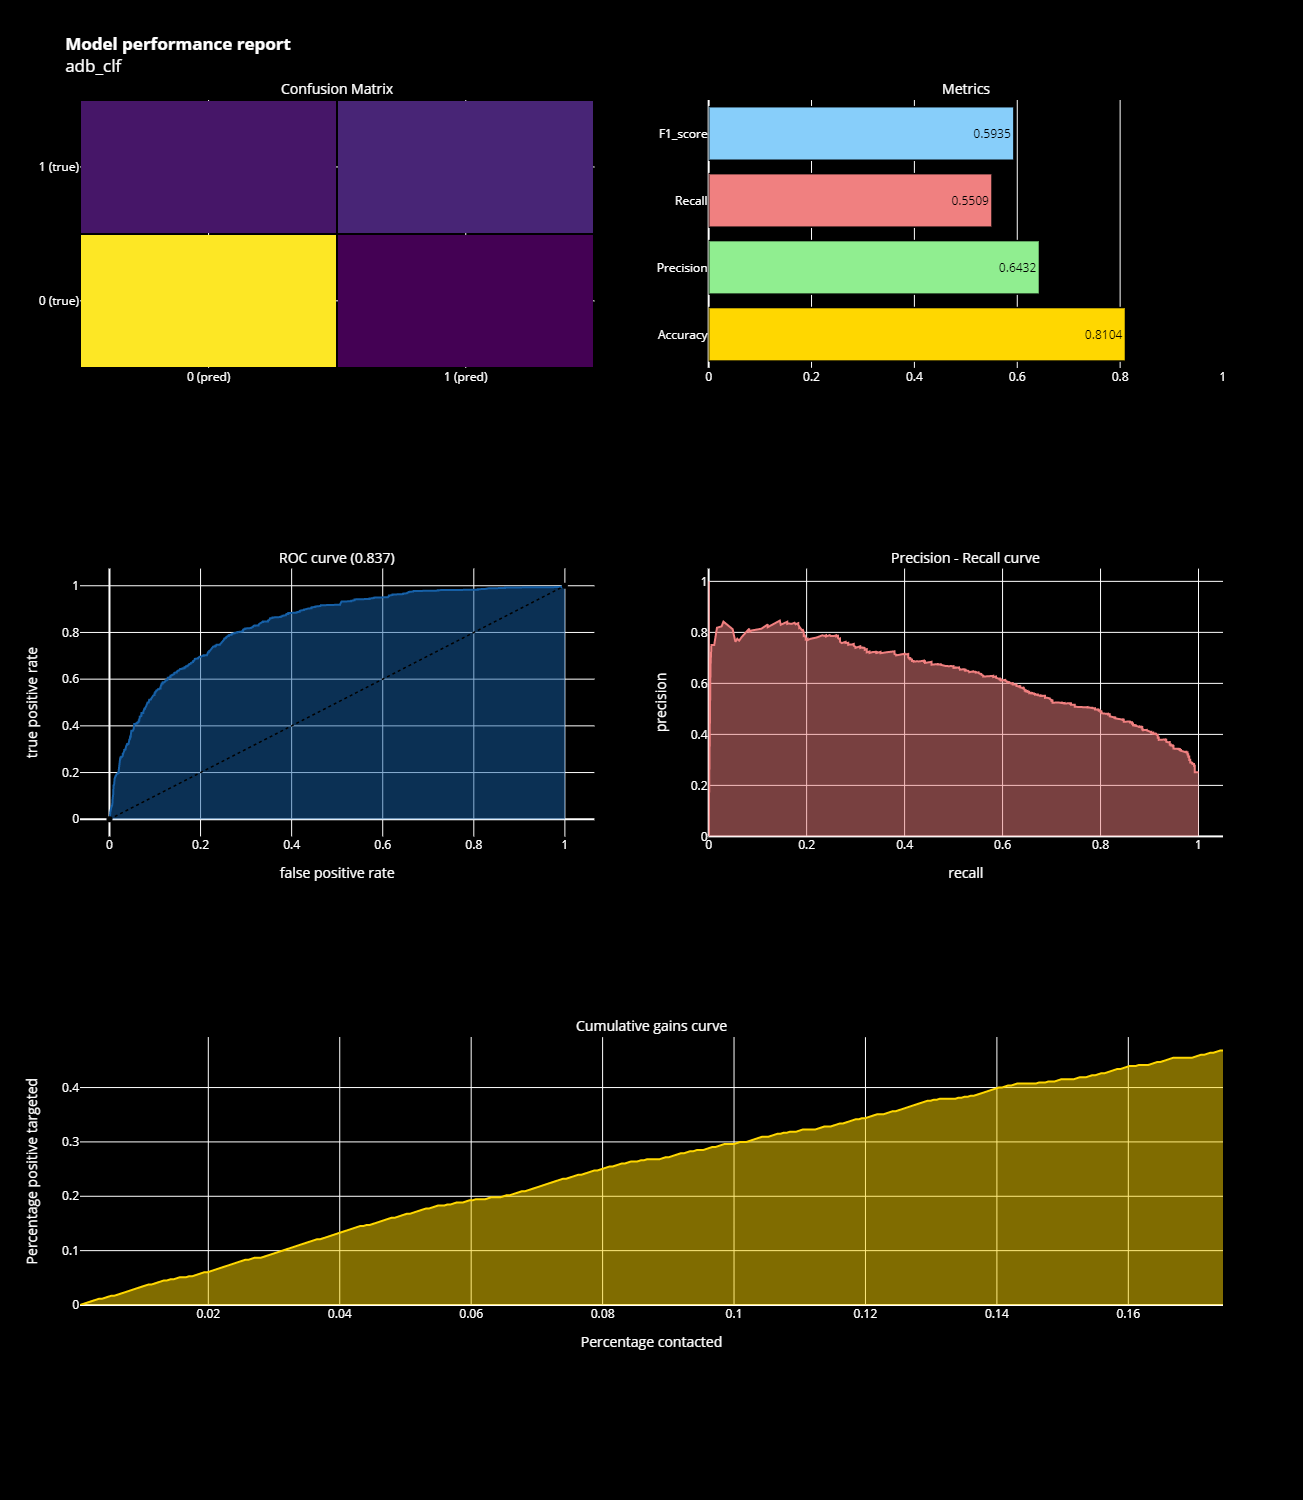

In [86]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier

adb_clf = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
adb_clf.fit(X_train,y_train)
y_pred = adb_clf.predict(X_test)
y_score = adb_clf.predict_proba(X_test)[:,1]

model_performance('adb_clf')

## AdaBoost - Cross Validation - 5 CVs

In [87]:
cross_val_metrics(adb_clf)

[accuracy] : 0.80717 (+/- 0.00698)
[precision] : 0.67313 (+/- 0.02153)
[recall] : 0.53504 (+/- 0.01415)
[f1] : 0.59596 (+/- 0.01240)
[roc_auc] : 0.84676 (+/- 0.01196)


# 4. Random Forest

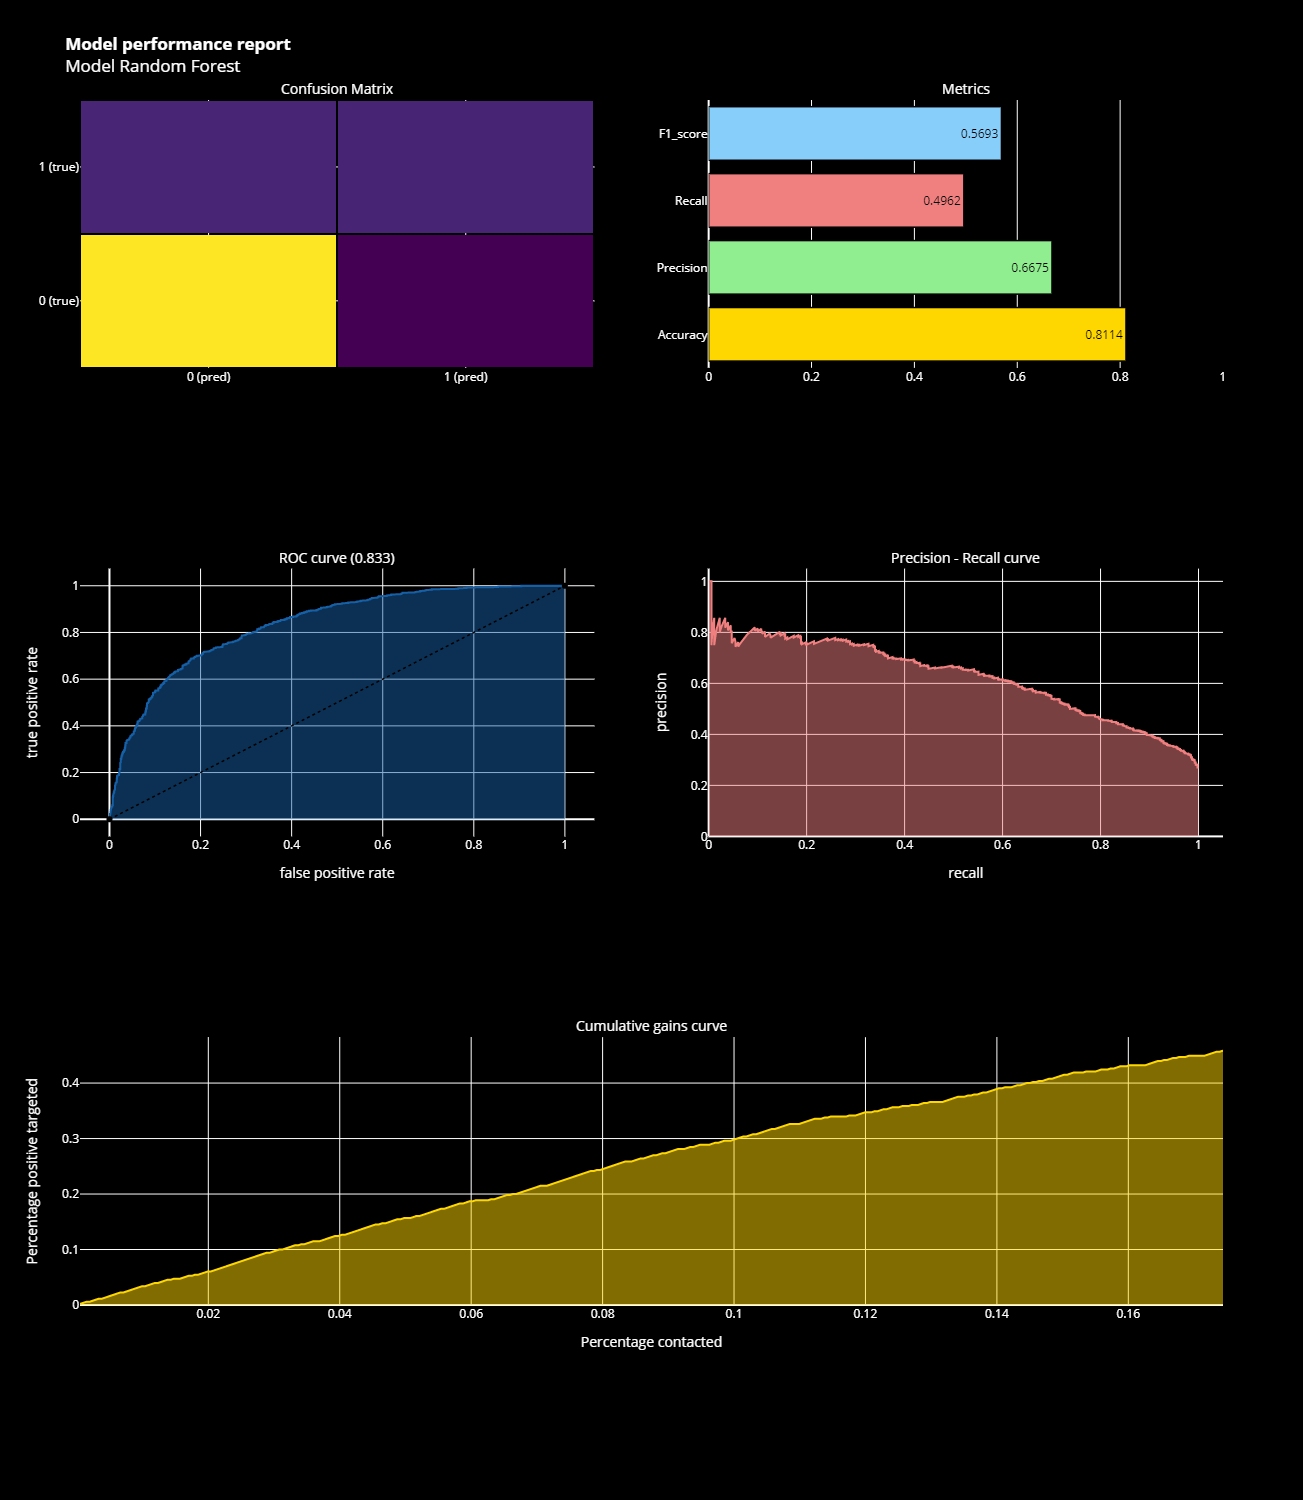

In [88]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
y_pred = model_rf.predict(X_test)
y_score = model_rf.predict_proba(X_test)[:,1]
model_performance('Model Random Forest')

# 5. XG Boost

In [89]:
from xgboost import XGBClassifier
from sklearn import metrics
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.7971563981042654

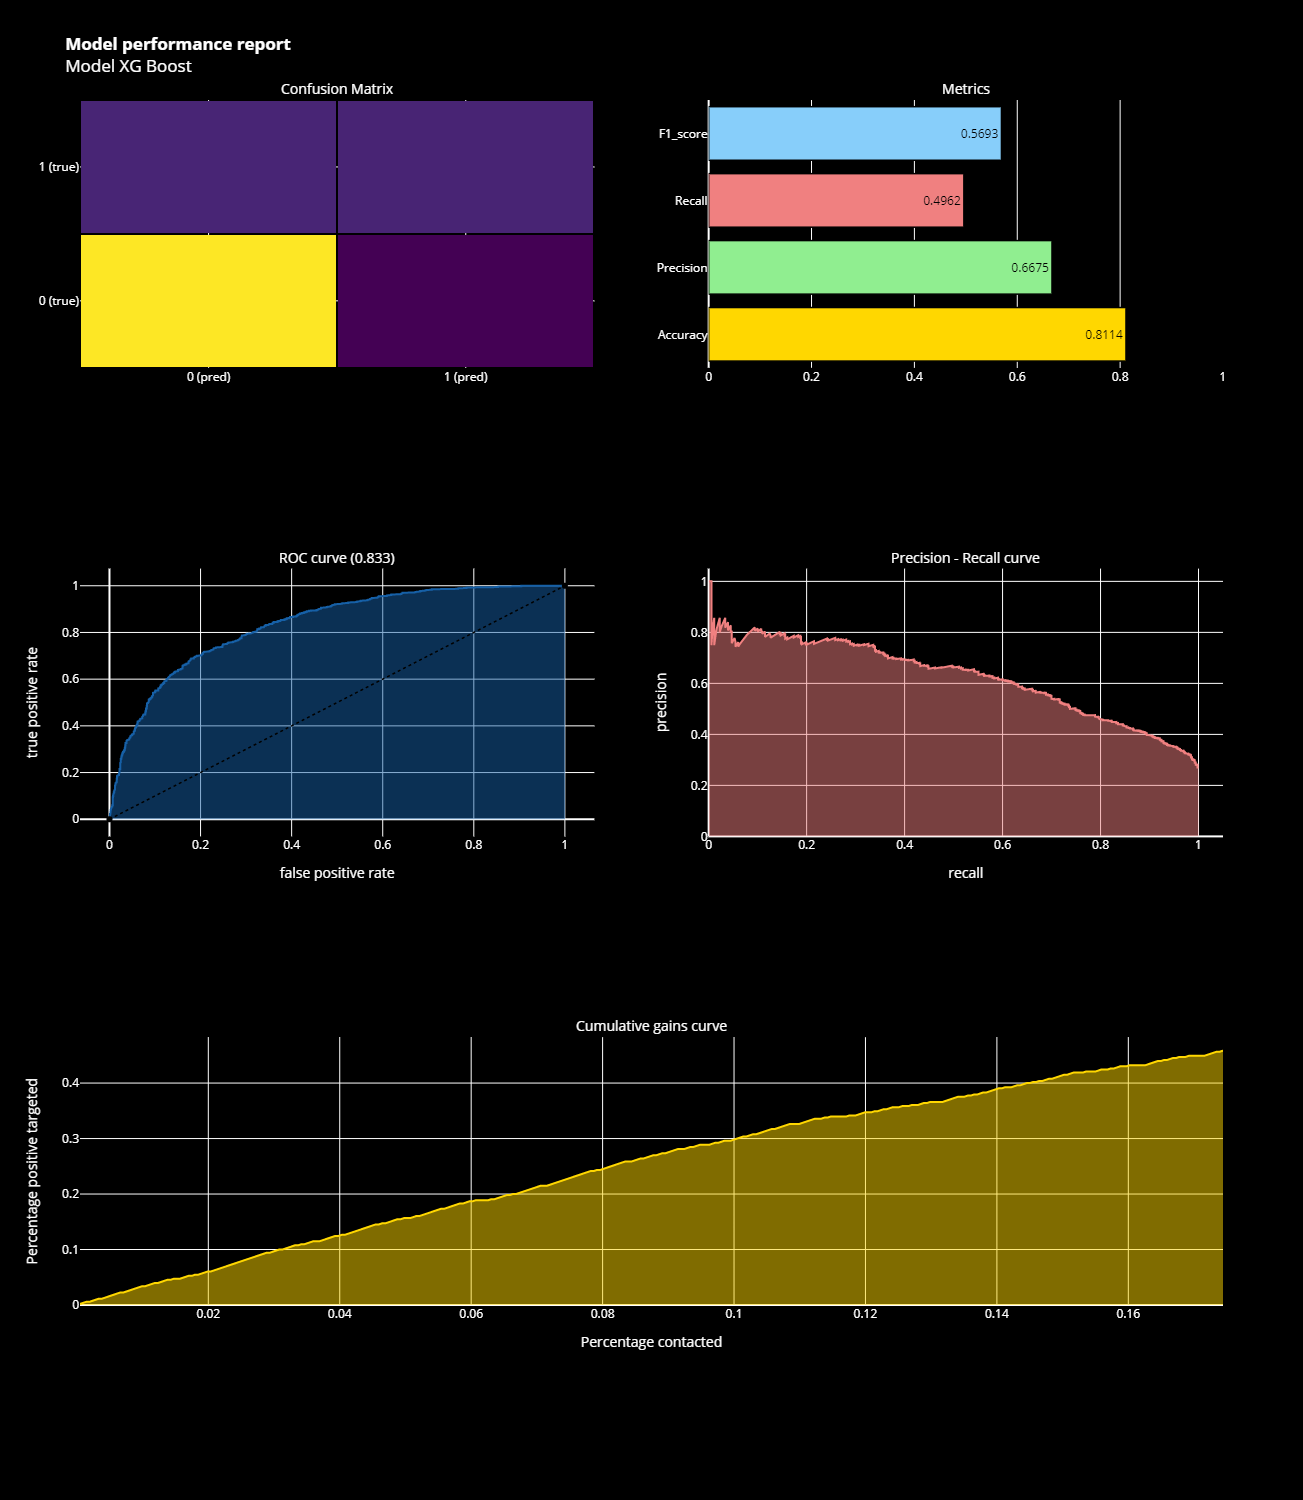

In [90]:
model_performance('Model XG Boost')